# Imports

In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torch.nn as F
import torchvision.transforms as transforms
import torchmetrics
import numpy as np

print(torch.version.cuda)

12.1


# Set Device

In [22]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Import MNIST Dataset

In [23]:
batch_size = 64

train_dataset = datasets.MNIST(root = './data',
                               train = True,
                               transform = transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std = (0.3105,))]),
                               download = True
                               )

test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std=(0.3105,))]),
                               download=True
                               )
        
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

# Set up the LeNet CNN

In [24]:
class LeNet(F.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.layer1 = F.Sequential(
            F.Conv2d(1, 6, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(6),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = F.Sequential(
            F.Conv2d(6, 16, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(16),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = F.Linear(400,120)
        self.relu = F.ReLU()
        self.fc1 = F.Linear(120,84)
        self.relu1 = F.ReLU()
        self.fc2 = F.Linear(84,num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Epoch tests
### Hyperparameters

In [25]:
num_classes = 100
learning_rate = 0.001
num_epochs = 20

metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up the CNN for use

In [26]:
model = LeNet(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=.9)

total_step = len(train_loader)

accuracy = []
f1 = []

### Run the CNN
Record the accuracy at the end of each epoch

In [27]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy.append(100 * correct / total)
        f1.append((100* metric_f1.compute()))
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {f1[-1]:.4f}%')
        print(f'Accuracy: {accuracy[-1]:.4f}%')
        

Epoch 1/20.. 
F1Score: 78.4083%
Accuracy: 96.2000%
Epoch 2/20.. 
F1Score: 87.5042%
Accuracy: 97.4100%
Epoch 3/20.. 
F1Score: 90.8233%
Accuracy: 98.0100%
Epoch 4/20.. 
F1Score: 92.5992%
Accuracy: 98.2900%
Epoch 5/20.. 
F1Score: 93.7203%
Accuracy: 98.4700%
Epoch 6/20.. 
F1Score: 94.4978%
Accuracy: 98.5100%
Epoch 7/20.. 
F1Score: 95.0786%
Accuracy: 98.5800%
Epoch 8/20.. 
F1Score: 95.5250%
Accuracy: 98.5900%
Epoch 9/20.. 
F1Score: 95.8811%
Accuracy: 98.6800%
Epoch 10/20.. 
F1Score: 96.1778%
Accuracy: 98.8000%
Epoch 11/20.. 
F1Score: 96.4279%
Accuracy: 98.8300%
Epoch 12/20.. 
F1Score: 96.6374%
Accuracy: 98.9600%
Epoch 13/20.. 
F1Score: 96.8208%
Accuracy: 98.8100%
Epoch 14/20.. 
F1Score: 96.9820%
Accuracy: 98.8900%
Epoch 15/20.. 
F1Score: 97.1248%
Accuracy: 98.9200%
Epoch 16/20.. 
F1Score: 97.2544%
Accuracy: 98.9500%
Epoch 17/20.. 
F1Score: 97.3681%
Accuracy: 99.0000%
Epoch 18/20.. 
F1Score: 97.4708%
Accuracy: 99.0300%
Epoch 19/20.. 
F1Score: 97.5665%
Accuracy: 98.9600%
Epoch 20/20.. 
F1Scor

### Graph

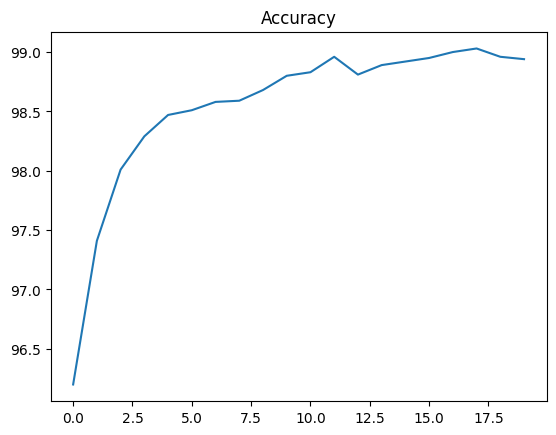

In [32]:
plt.plot(accuracy)
plt.title('Accuracy')
plt.show()

In [29]:
print("Maximum accuracy of the network on the 10000 test images: {} at epoch {}".format(np.max(accuracy), np.argmax(accuracy)))

Maximum accuracy of the network on the 10000 test images: 99.03 at epoch 17


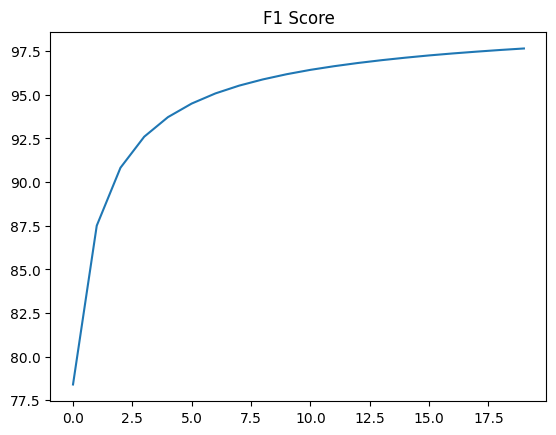

In [30]:
plt.plot(torch.stack(f1).cpu())
plt.title('F1 Score')
plt.show()

# Optimal Learning Rate
### Hyperparameters

In [10]:
batch_size = 64
num_classes = 100
learning_rate = [1,0.1,0.01,0.001,0.0001,0.00001]
num_epochs = 17
error = []
accuracy = []
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

# Set up and run the CNN
Record the error at the end of each iteration

In [11]:
for i in learning_rate:    
    model = LeNet(num_classes = num_classes).to(device)
    
    cost = F.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=i, momentum=.9)
    
    total_step = len(train_loader)
    error.append([])
    for epoch in range(num_epochs):
        
        for j, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error[-1].append(loss.item())
            metric_f1.update(outputs, labels)
            
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total+=labels.size(0)
                correct+=(predicted == labels).sum().item()
            accuracy.append(100 * correct / total)
            print(f'Learning Rate {i}.. ')
            print(f'Epoch {epoch+1}/{num_epochs}.. ')
            print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
            print(f'Accuracy: {accuracy[-1]:.4f}%')

Learning Rate 1.. 
Epoch 1/17.. 
F1Score: 9.8567%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 2/17.. 
F1Score: 9.8642%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 3/17.. 
F1Score: 9.8667%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 4/17.. 
F1Score: 9.8679%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 5/17.. 
F1Score: 9.8687%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 6/17.. 
F1Score: 9.8692%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 7/17.. 
F1Score: 9.8695%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 8/17.. 
F1Score: 9.8698%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 9/17.. 
F1Score: 9.8700%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 10/17.. 
F1Score: 9.8702%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 11/17.. 
F1Score: 9.8703%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 12/17.. 
F1Score: 9.8704%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 13/17.. 
F1Score: 9.8705%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 14/17.. 
F1Score: 9.8706%
Accuracy: 9.8000%
Learning Rate 1.. 
Epoch 15/17.. 
F1Score: 

### Graphs

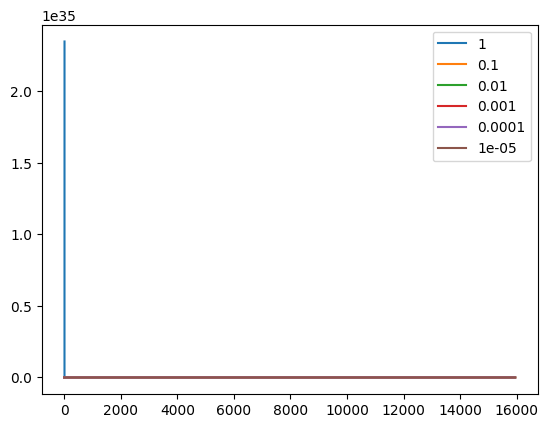

In [12]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### Remove the first 2 cases because the scale is thrown off.

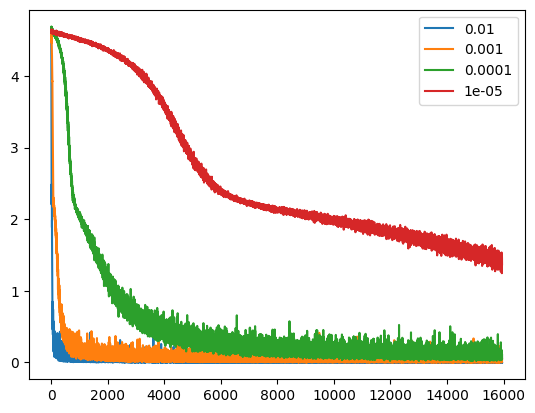

In [13]:
for i in range(2,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### All Individual graphs

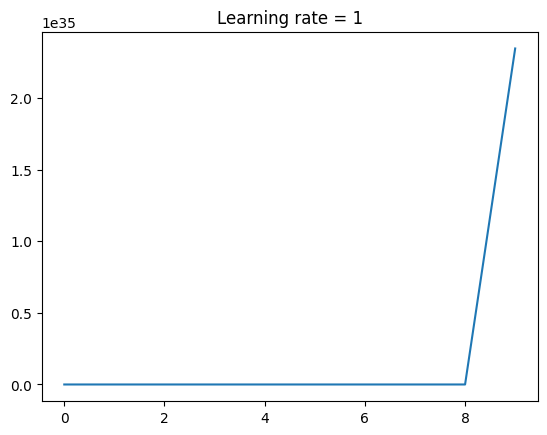

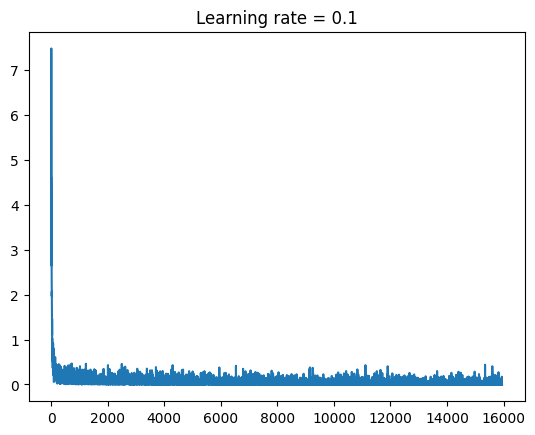

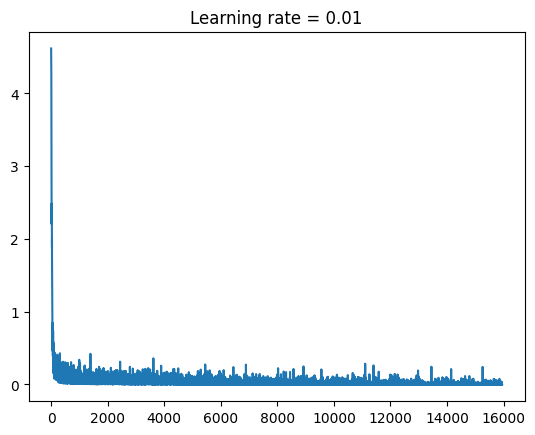

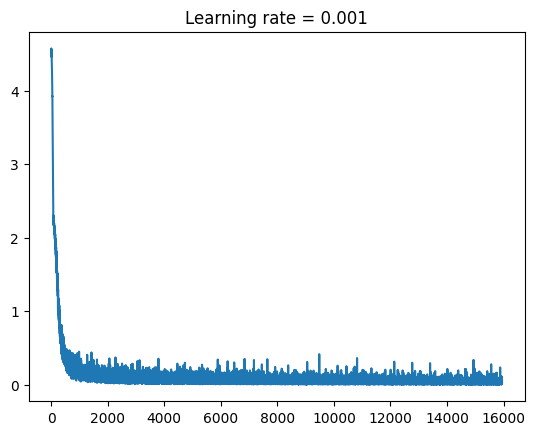

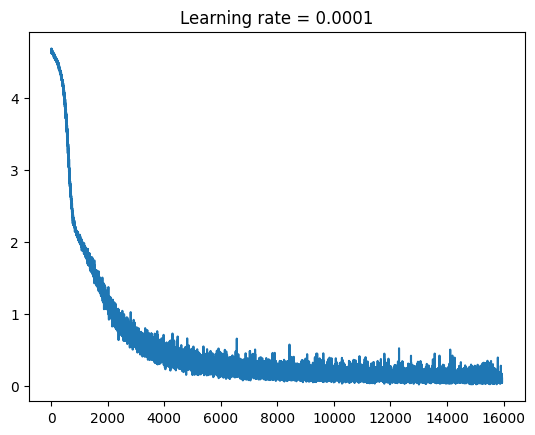

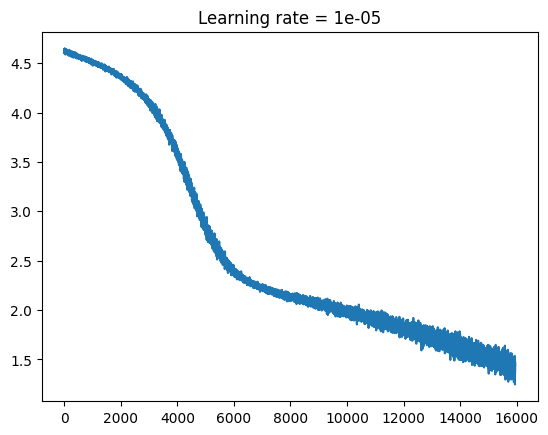

In [14]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
    plt.title('Learning rate = {}'.format(learning_rate[i]))
    plt.show()

# Adam Vs. SGD

### Hyperparameters

In [15]:
batch_size = 64
num_classes = 100
learning_rate = 0.001
num_epochs = 10
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up Adam

In [16]:
model = LeNet(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

accuracy = [[],[]]

### Run the CNN with Adam
Record the accuracy at the end of each epoch

In [17]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[0].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[0][-1]:.4f}%')

Epoch 1/10.. 
F1Score: 93.7950%
Accuracy: 97.0700%
Epoch 2/10.. 
F1Score: 95.9642%
Accuracy: 98.6400%
Epoch 3/10.. 
F1Score: 96.8478%
Accuracy: 98.9500%
Epoch 4/10.. 
F1Score: 97.3433%
Accuracy: 98.7200%
Epoch 5/10.. 
F1Score: 97.6667%
Accuracy: 98.7300%
Epoch 6/10.. 
F1Score: 97.9175%
Accuracy: 98.7400%
Epoch 7/10.. 
F1Score: 98.1031%
Accuracy: 99.0500%
Epoch 8/10.. 
F1Score: 98.2592%
Accuracy: 99.0800%
Epoch 9/10.. 
F1Score: 98.3852%
Accuracy: 99.0000%
Epoch 10/10.. 
F1Score: 98.4930%
Accuracy: 99.1300%


### Set up SGD

In [18]:
model = LeNet(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

total_step = len(train_loader)

accuracy[1] = []

### Run the CNN with SGD
Record the accuracy at the end of each epoch

In [19]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[1].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[1][-1]:.4f}%')

Epoch 1/10.. 
F1Score: 98.0038%
Accuracy: 98.4200%
Epoch 2/10.. 
F1Score: 98.0190%
Accuracy: 98.6700%
Epoch 3/10.. 
F1Score: 98.0699%
Accuracy: 98.6700%
Epoch 4/10.. 
F1Score: 98.1298%
Accuracy: 98.9900%
Epoch 5/10.. 
F1Score: 98.1981%
Accuracy: 98.9700%
Epoch 6/10.. 
F1Score: 98.2610%
Accuracy: 99.0400%
Epoch 7/10.. 
F1Score: 98.3256%
Accuracy: 99.0700%
Epoch 8/10.. 
F1Score: 98.3875%
Accuracy: 98.8700%
Epoch 9/10.. 
F1Score: 98.4439%
Accuracy: 99.0600%
Epoch 10/10.. 
F1Score: 98.4990%
Accuracy: 98.6800%


### Graph

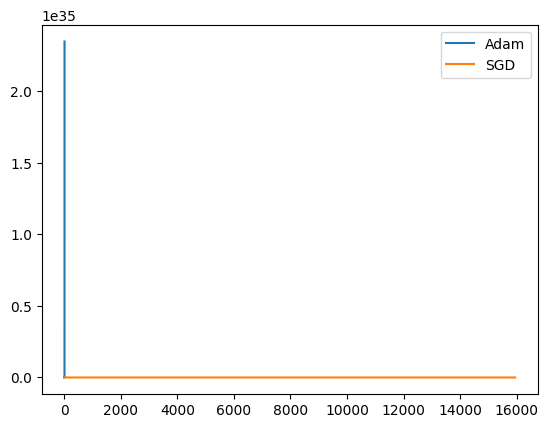

In [20]:
plt.plot(error[0], label='Adam')
plt.plot(error[1], label='SGD')
plt.legend()
plt.show()